# Unsupervised surgery pipeline with SCVI

In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Set relevant anndata.obs labels and training length

Here we use the CelSeq2 and SS2 studies as query data and the other 3 studies as reference atlas. We strongly suggest to use earlystopping to avoid over-fitting. The best earlystopping criteria is the 'elbo' for SCVI.

In [4]:
condition_key = 'study'
cell_type_key = 'cell_type'
target_conditions = ['Pancreas CelSeq2', 'Pancreas SS2']


vae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

### Download Dataset and split into reference dataset and query dataset

In [5]:
url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
output = 'pancreas.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd
To: C:\Users\sergei.rybakov\projects\notebooks\pancreas.h5ad
126MB [00:40, 3.14MB/s] 


'pancreas.h5ad'

In [6]:
adata_all = sc.read('pancreas.h5ad')

In [7]:
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)].copy()
target_adata = adata[adata.obs[condition_key].isin(target_conditions)].copy()

In [8]:
source_adata

AnnData object with n_obs × n_vars = 10294 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [9]:
target_adata

AnnData object with n_obs × n_vars = 5387 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

### Create SCVI model and train it on reference dataset

In [10]:
sca.dataset.setup_anndata(source_adata, batch_key=condition_key)

INFO      Using batches from adata.obs["study"]                                              
INFO      No label_key inputted, assuming all cells have same label                          
INFO      Using data from adata.X                                                            
INFO      Computing library size prior per batch                                             
INFO      Successfully registered anndata object containing 10294 cells, 1000 vars, 3        
          batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates  
          and 0 extra continuous covariates.                                                 
INFO      Please do not further modify adata until model is trained.                         


The parameters chosen here proofed to work best in the case of surgery with SCVI.

In [12]:
vae = sca.models.SCVI(
    source_adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [13]:
vae.train(n_epochs=vae_epochs, frequency=1, early_stopping_kwargs=early_stopping_kwargs)

INFO      Training for 500 epochs                                                            
INFO      KL warmup for 400 epochs                                                           
Training...:  34%|██████████████████████▋                                            | 169/500 [06:38<15:09,  2.75s/it]INFO                                                                                         
          Stopping early: no improvement of more than 0 nats in 10 epochs                    
INFO      If the early stopping criterion is too strong, please instantiate it with different
          parameters in the train method.                                                    
Training...:  34%|██████████████████████▋                                            | 169/500 [06:41<13:06,  2.37s/it]
INFO      Training is still in warming up phase. If your applications rely on the posterior  
          quality, consider training for more epochs or reducing the kl warmup.              
INFO     

### Create anndata file of latent representation and compute UMAP

In [14]:
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = source_adata.obs[condition_key].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


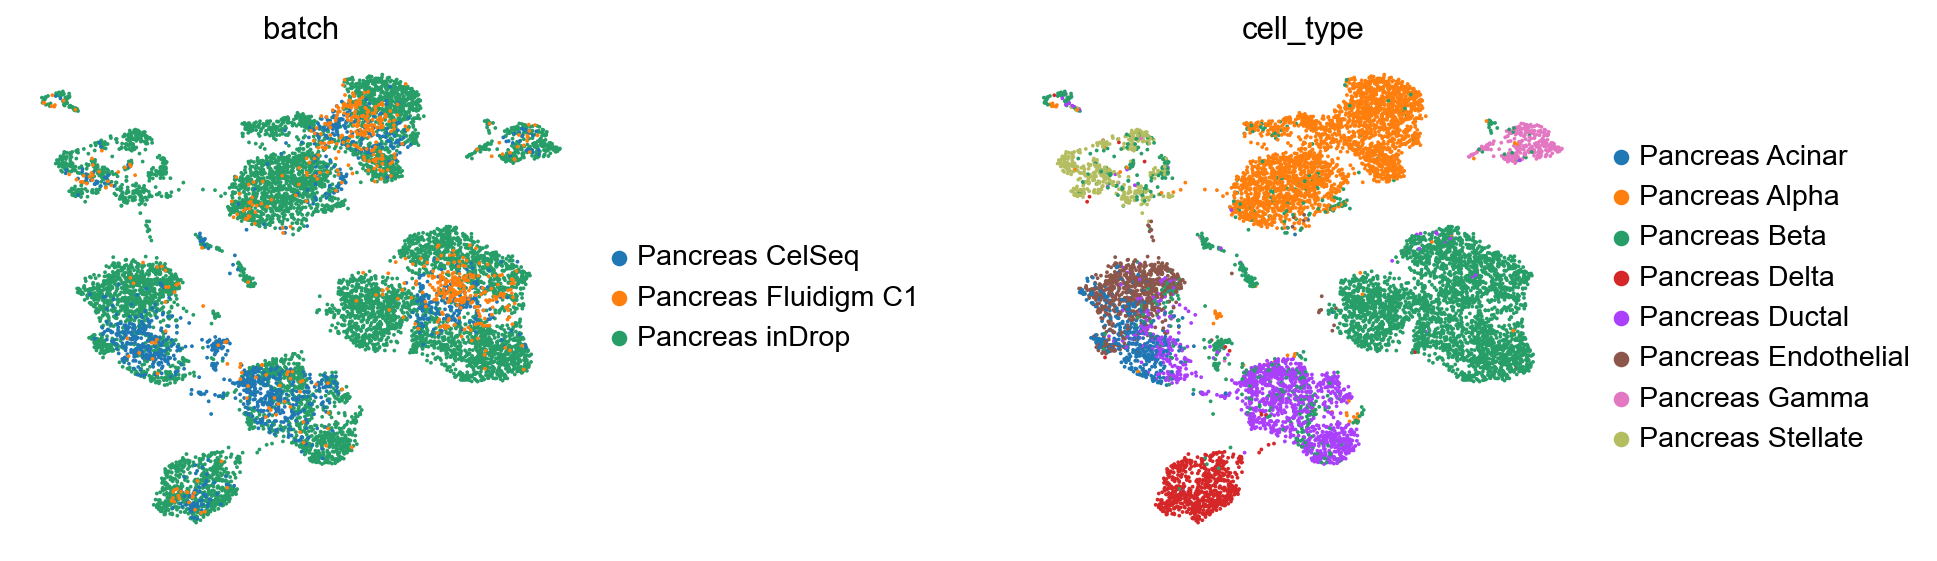

In [15]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

After pretraining the model can be saved for later use

In [16]:
ref_path = 'ref_model/'
vae.save(ref_path, overwrite=True)

### Perform surgery on reference model and train on query dataset

In [17]:
model = sca.models.SCVI.load_query_data(
    target_adata,
    ref_path,
    freeze_dropout = True,
)

INFO      .obs[_scvi_labels] not found in target, assuming every cell is same category       
INFO      Using data from adata.X                                                            
INFO      Computing library size prior per batch                                             
INFO      Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']    
INFO      Successfully registered anndata object containing 5387 cells, 1000 vars, 5 batches,
          1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
          extra continuous covariates.                                                       
WARNING   Make sure the registered X field in anndata contains unnormalized count data.      


In [18]:
model.train(n_epochs=surgery_epochs, frequency=1, early_stopping_kwargs=early_stopping_kwargs, weight_decay=0)

INFO      Training for 500 epochs                                                            
INFO      KL warmup for 400 epochs                                                           
Training...:  14%|█████████▊                                                          | 72/500 [01:27<08:40,  1.22s/it]INFO                                                                                         
          Stopping early: no improvement of more than 0 nats in 10 epochs                    
INFO      If the early stopping criterion is too strong, please instantiate it with different
          parameters in the train method.                                                    
Training...:  14%|█████████▊                                                          | 72/500 [01:28<08:48,  1.24s/it]
INFO      Training is still in warming up phase. If your applications rely on the posterior  
          quality, consider training for more epochs or reducing the kl warmup.              
INFO     

In [19]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
query_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

WARNING   Make sure the registered X field in anndata contains unnormalized count data.      


... storing 'cell_type' as categorical
... storing 'batch' as categorical


<Figure size 320x320 with 0 Axes>

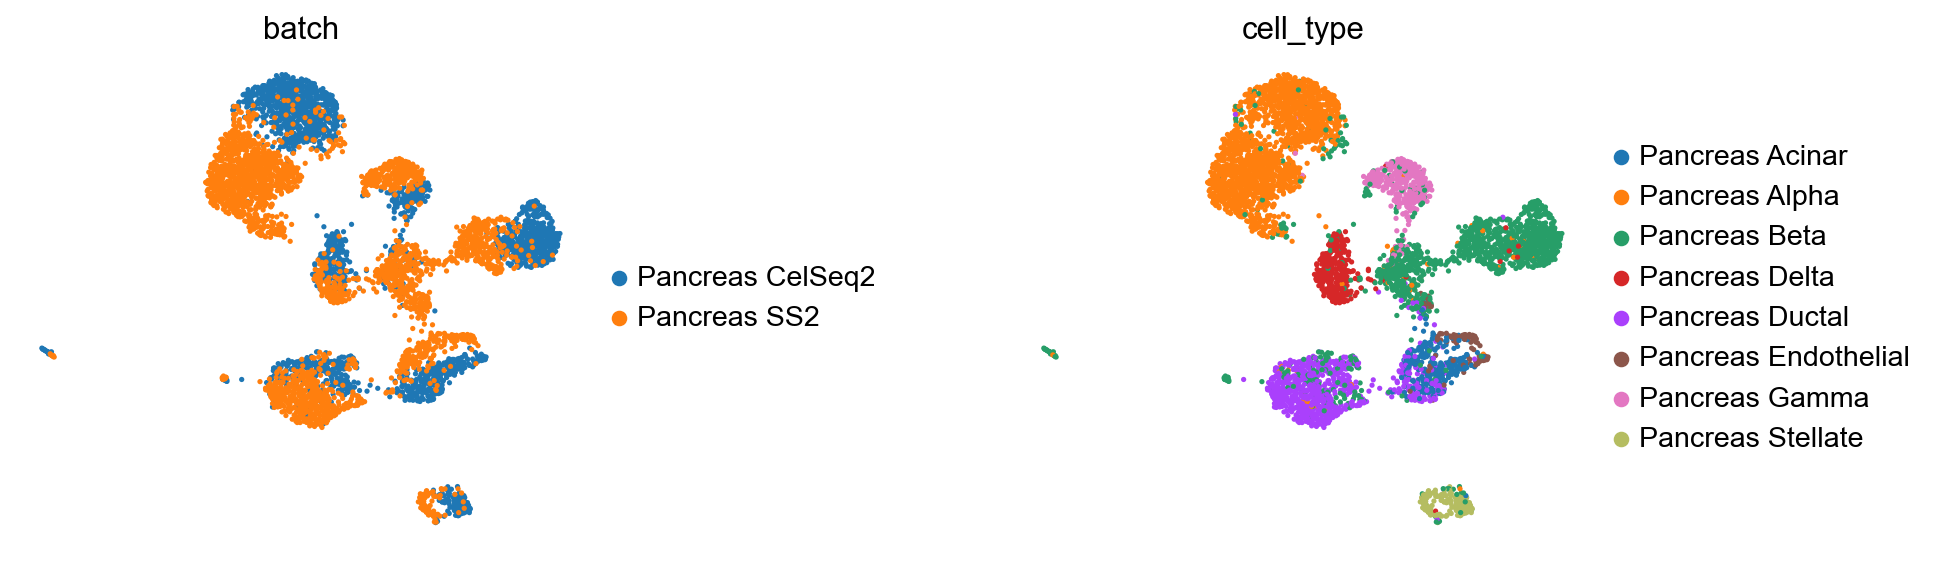

In [20]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)
plt.figure()
sc.pl.umap(
    query_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)

In [21]:
surgery_path = 'surgery_model'
model.save(surgery_path, overwrite=True)

### Get latent representation of reference + query dataset and compute UMAP

In [22]:
adata_full = source_adata.concatenate(target_adata)
full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))
full_latent.obs['cell_type'] = adata_full.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata_full.obs[condition_key].tolist()

INFO      Input adata not setup with scvi. attempting to transfer anndata setup              
INFO      Using data from adata.X                                                            
INFO      Computing library size prior per batch                                             
INFO      Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']    
INFO      Successfully registered anndata object containing 15681 cells, 1000 vars, 5        
          batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates  
          and 0 extra continuous covariates.                                                 


... storing 'cell_type' as categorical
... storing 'batch' as categorical


<Figure size 320x320 with 0 Axes>

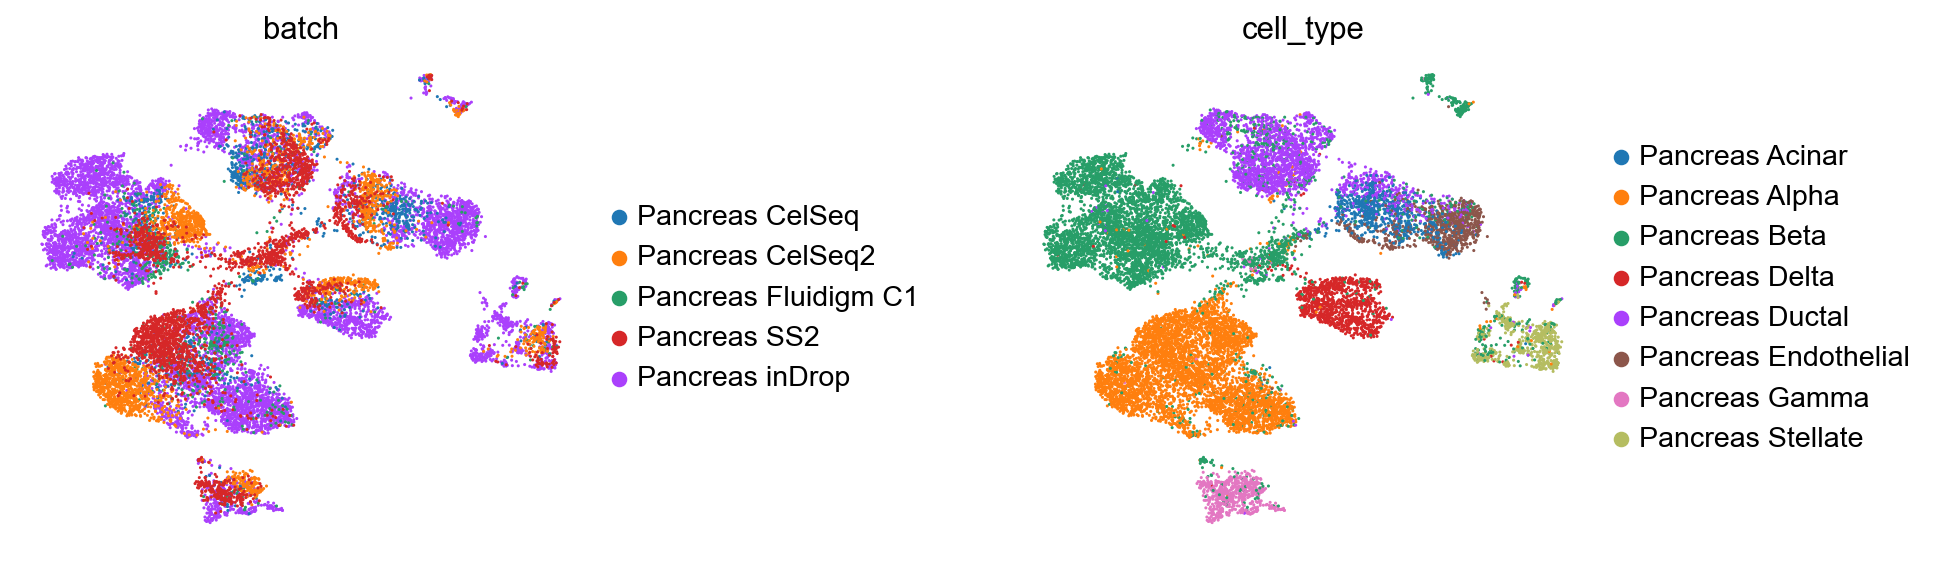

In [23]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
plt.figure()
sc.pl.umap(
    full_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)